In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

def OK():
    print("OK")

# Carregar dados
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
mapping = pd.read_csv('../data/mapping.csv')

In [2]:
print(mapping)

   generic_name                                      original_name
0      feature1                                      ENTRADAS (v3)
1      feature2                                    Ammonia e afins
2      feature3                                   Calcário e gesso
3      feature4                                Emissões pesticidas
4      feature5                                Energia da biomassa
5      feature6                             Energia elétrica (kwh)
6      feature7                                Esterco animal (kg)
7      feature8                                 Esterco verde (kg)
8      feature9                   Fungicida, herbicida e pesticida
9     feature10                                    Macronutrientes
10    feature11                                    Micronutrientes
11    feature12                                  Ocuppation, total
12    feature13                                               Seed
13    feature14                  Transformation total, to and 

In [3]:
# 3. Renomear colunas nos dataframes
rename_dict = dict(zip(mapping['generic_name'], mapping['original_name']))

# Para o conjunto de treino
train = train.rename(columns=rename_dict)

# Para o conjunto de teste
test = test.rename(columns=rename_dict)

# Verificar resultado
print("Colunas do treino renomeadas:")
print(train.columns.tolist())

print("\nColunas do teste renomeadas:")
print(test.columns.tolist())

#Salvar novos datasets
train.to_csv('../data/train_renomeado.csv', index=False)
test.to_csv('../data/test_renomeado.csv', index=False)

Colunas do treino renomeadas:
['ENTRADAS (v3)', 'Ammonia e afins', 'Calcário e gesso', 'Emissões pesticidas', 'Energia da biomassa', 'Energia elétrica (kwh)', 'Esterco animal (kg)', 'Esterco verde (kg)', 'Fungicida, herbicida e pesticida', 'Macronutrientes', 'Micronutrientes', 'Ocuppation, total', 'Seed', 'Transformation total, to and from', 'Urea', 'acidification - acidification (incl. fate, average Europe total, A&B)', 'climate change - global warming potential (GWP100)', 'ecotoxicity: freshwater - freshwater aquatic ecotoxicity (FAETP inf)', 'ecotoxicity: marine - marine aquatic ecotoxicity (MAETP inf)', 'ecotoxicity: terrestrial - terrestrial ecotoxicity (TETP inf)', 'energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels', 'eutrophication - eutrophication (fate not incl.)', 'human toxicity - human toxicity (HTP inf)', 'material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)', 'ozone depletion - ozone layer de

In [11]:
# Informações básicas
print("Shape do treino:", train.shape)
print("Shape do teste:", test.shape)
print("\nInfo do dataset:")


Shape do treino: (708, 26)
Shape do teste: (178, 15)

Info do dataset:


In [5]:
# Verificar valores ausentes
print("\nValores ausentes no treino:")
print(train.isnull().sum().sort_values(ascending=False))


Valores ausentes no treino:
ENTRADAS (v3)                                                                                            0
Ammonia e afins                                                                                          0
Calcário e gesso                                                                                         0
Emissões pesticidas                                                                                      0
Energia da biomassa                                                                                      0
Energia elétrica (kwh)                                                                                   0
Esterco animal (kg)                                                                                      0
Esterco verde (kg)                                                                                       0
Fungicida, herbicida e pesticida                                                                         0
Macronut

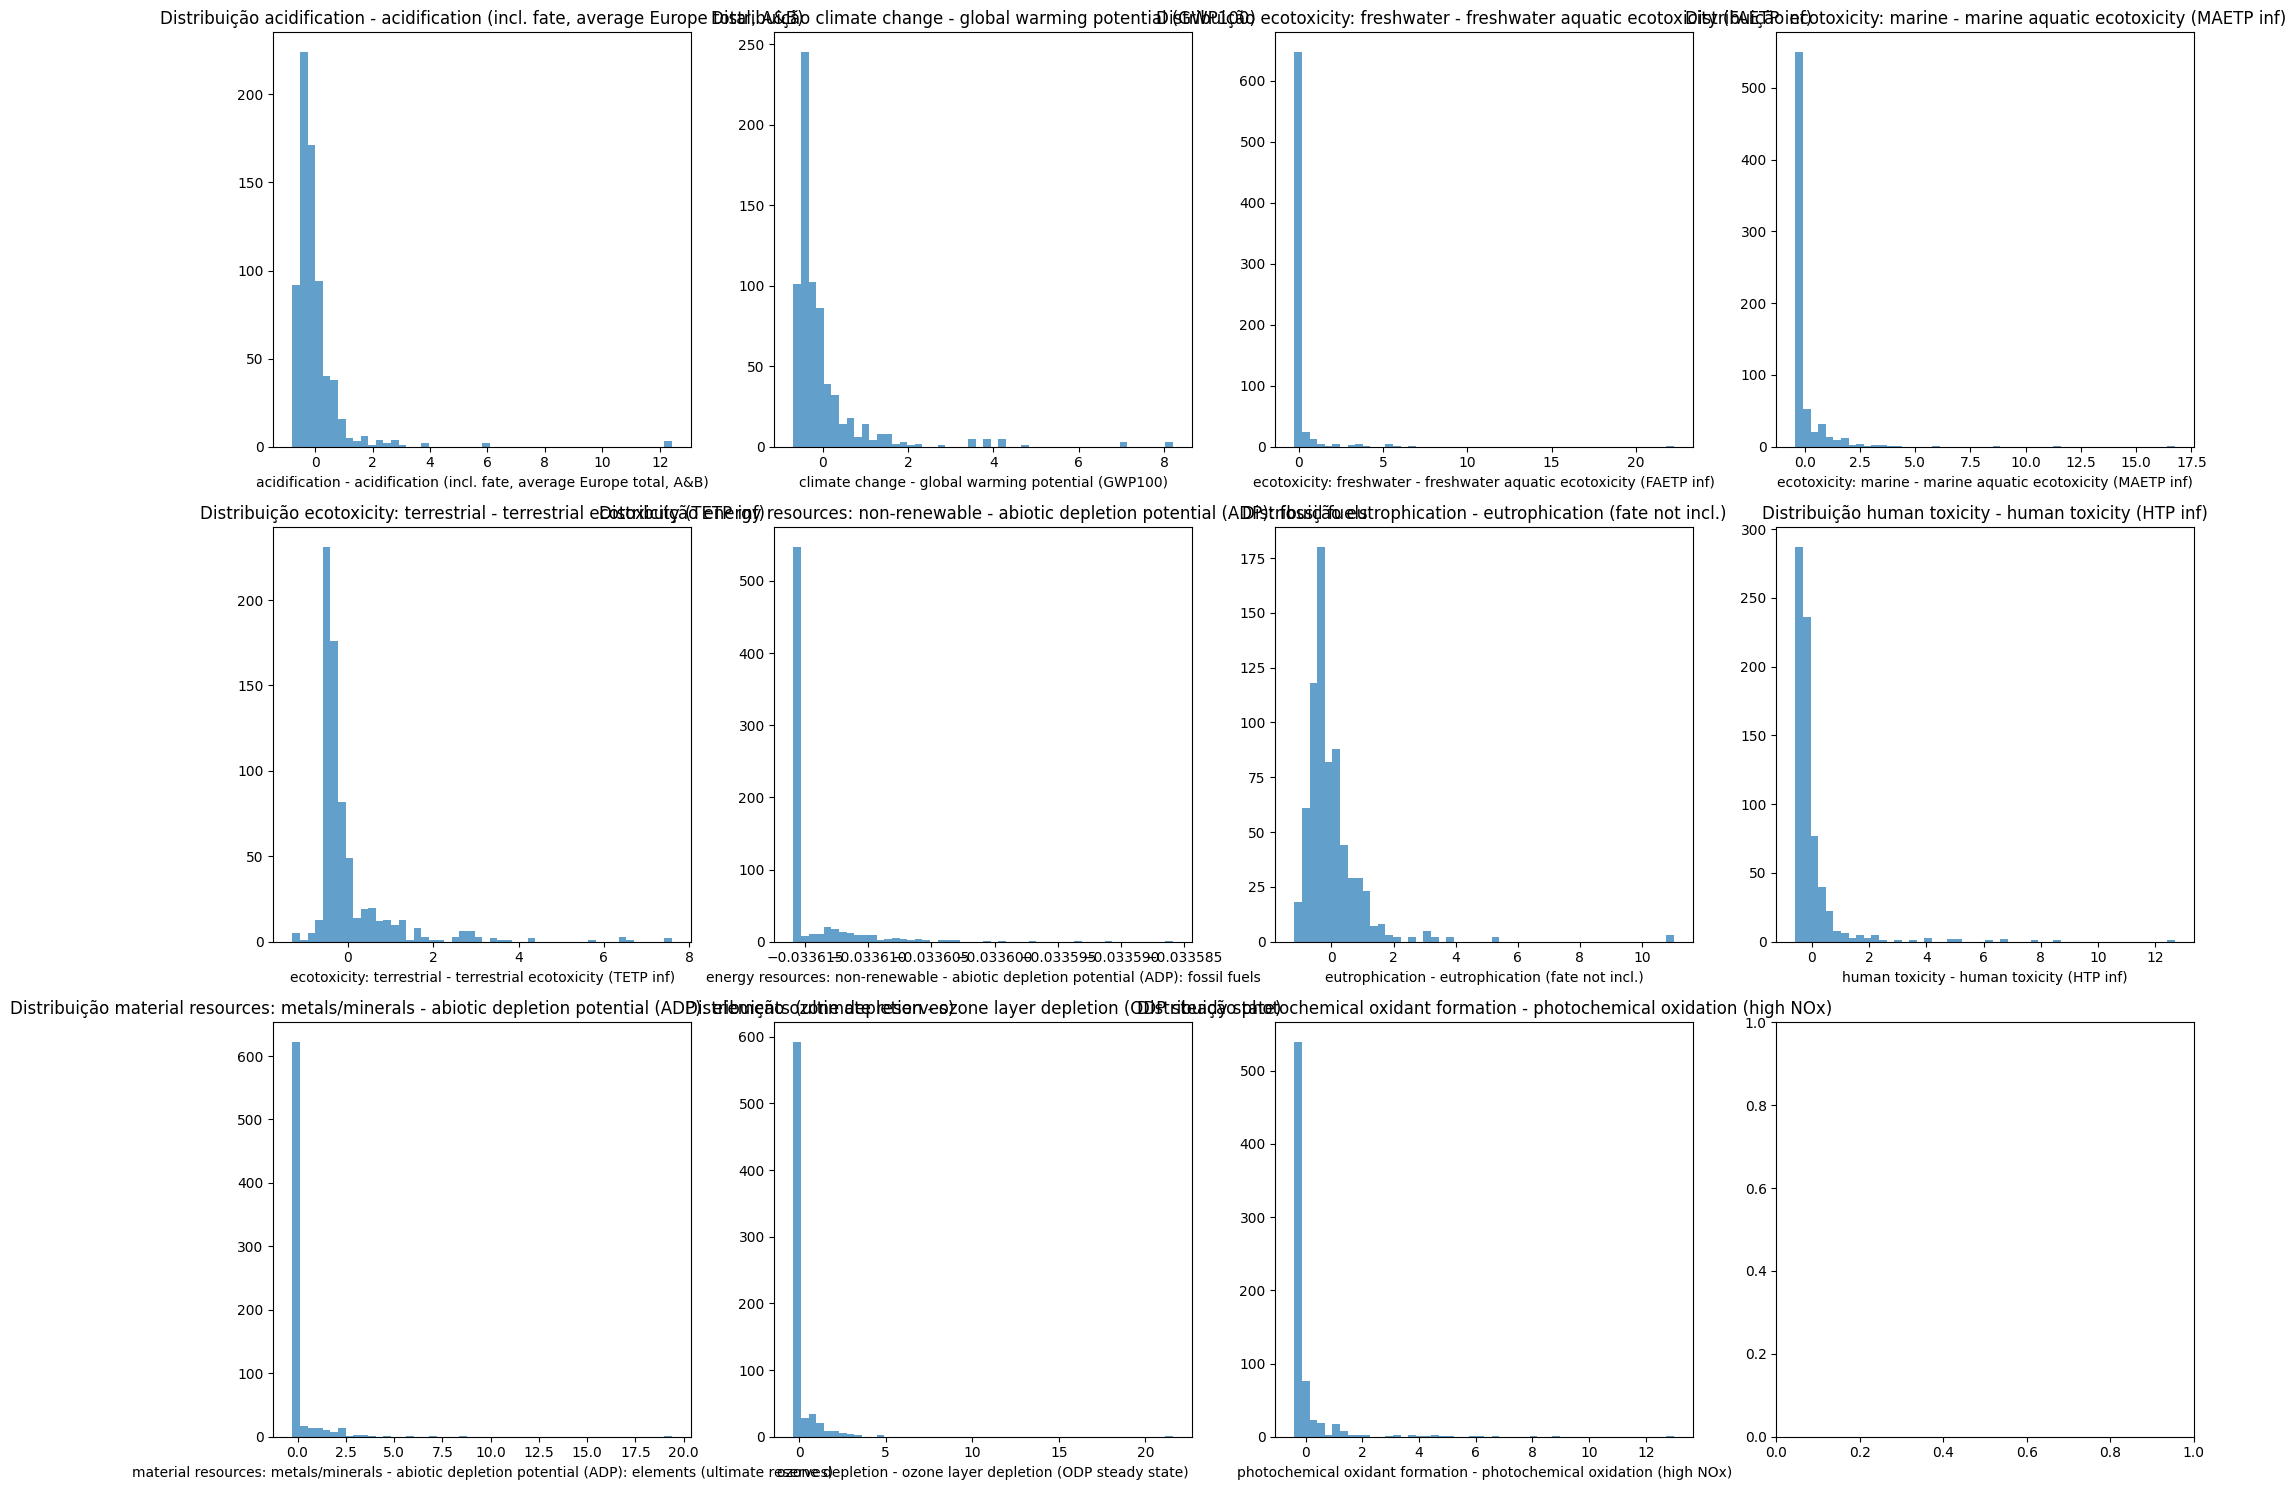

In [6]:
# Identificar colunas target (target1 a target11)
target_cols = train.columns[-11:]  # Os últimos 11 elementos são sempre os targets
feature_cols = [col for col in train.columns if col not in target_cols and col != 'Id']

# Distribuição dos targets
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, target in enumerate(target_cols):
    axes[i].hist(train[target], bins=50, alpha=0.7)
    axes[i].set_title(f'Distribuição {target}')
    axes[i].set_xlabel(target)

plt.tight_layout()
plt.show()


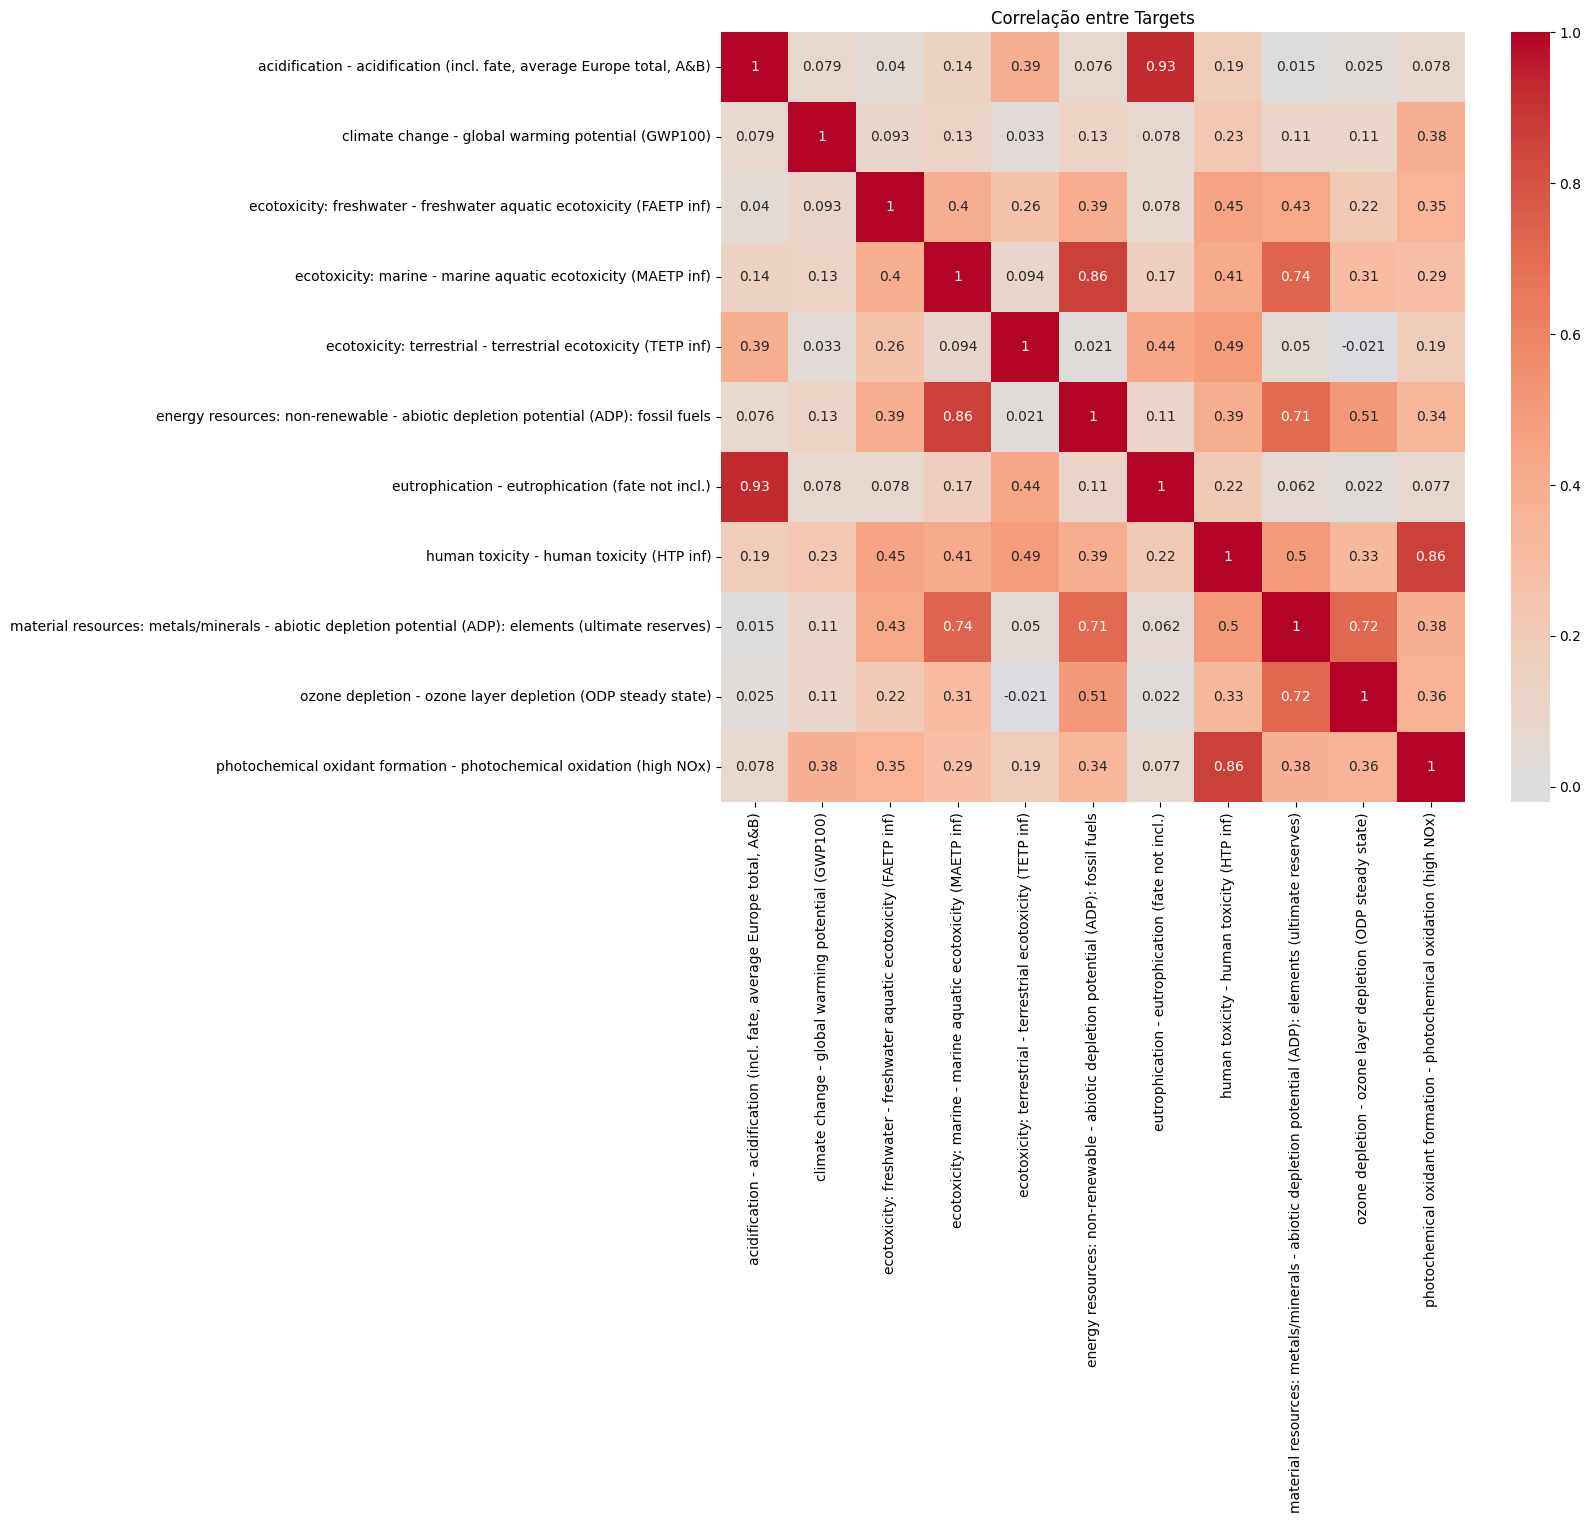

In [7]:
target_corr = train[target_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlação entre Targets')
plt.show()

In [8]:
# Tipos de variáveis
print("Tipos de dados:")
print(train[feature_cols].dtypes.value_counts())

# Variáveis categóricas vs numéricas
categorical_features = train[feature_cols].select_dtypes(include=['object']).columns.tolist()
numerical_features = train[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Features categóricas: {len(categorical_features)}")
print(f"Features numéricas: {len(numerical_features)}")

Tipos de dados:
float64    14
object      1
Name: count, dtype: int64
Features categóricas: 1
Features numéricas: 14


In [10]:
# Distribuição das features numéricas mais importantes
if len(numerical_features) > 0:
    # Calcular correlação com targets
    feature_importance = {}
    for feature in numerical_features[:20]:  # Top 20 features
        correlations = []
        for target in target_cols:
            corr = abs(train[feature].corr(train[target]))
            correlations.append(corr)
        feature_importance[feature] = np.mean(correlations)

    # Top features por correlação
    top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 features por correlação média com targets:")
    for feature, corr in top_features:
        print(f"{feature}: {corr:.3f}")


Top 10 features por correlação média com targets:
Transformation total, to and from: 0.374
Energia da biomassa: 0.255
Micronutrientes: 0.230
Esterco animal (kg): 0.223
Fungicida, herbicida e pesticida: 0.220
Calcário e gesso: 0.153
Emissões pesticidas: 0.147
Macronutrientes: 0.119
Ocuppation, total: 0.112
Urea: 0.099


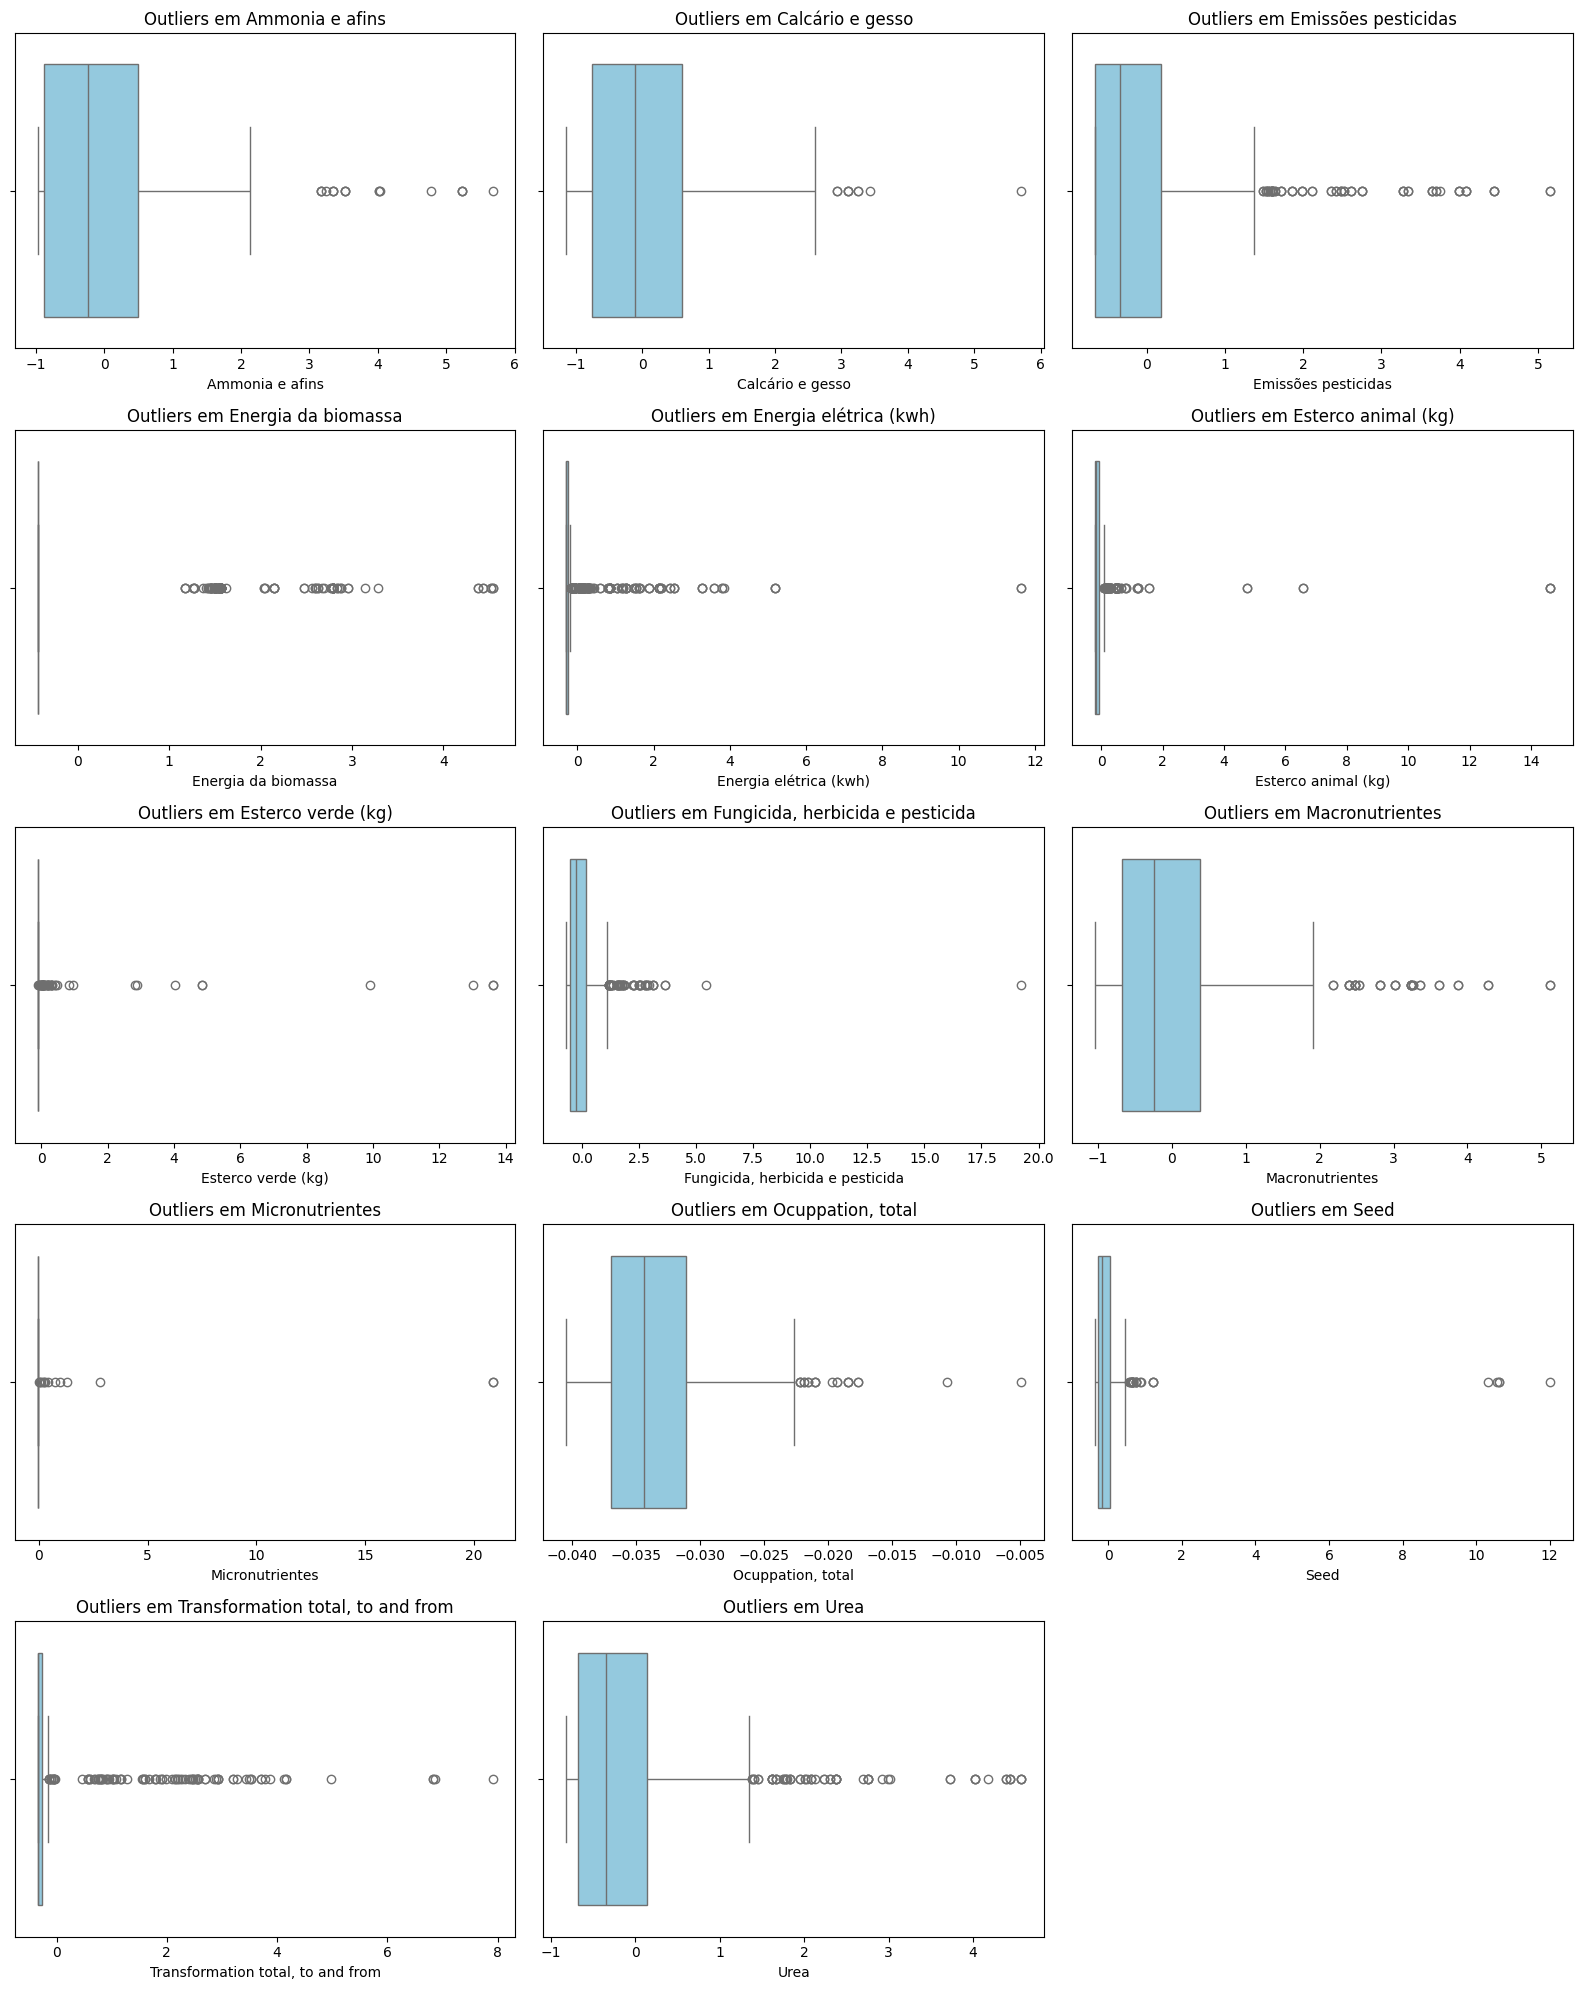

In [13]:
num_features = train.select_dtypes(include=['float64']).columns.drop(target_cols)

plt.figure(figsize=(16, 20))
for i, col in enumerate(num_features):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=train[col], color='skyblue')
    plt.title(f'Outliers em {col}')
plt.tight_layout()

Text(0.5, 1.0, 'Correlação entre Features de Insumos Agrícolas')

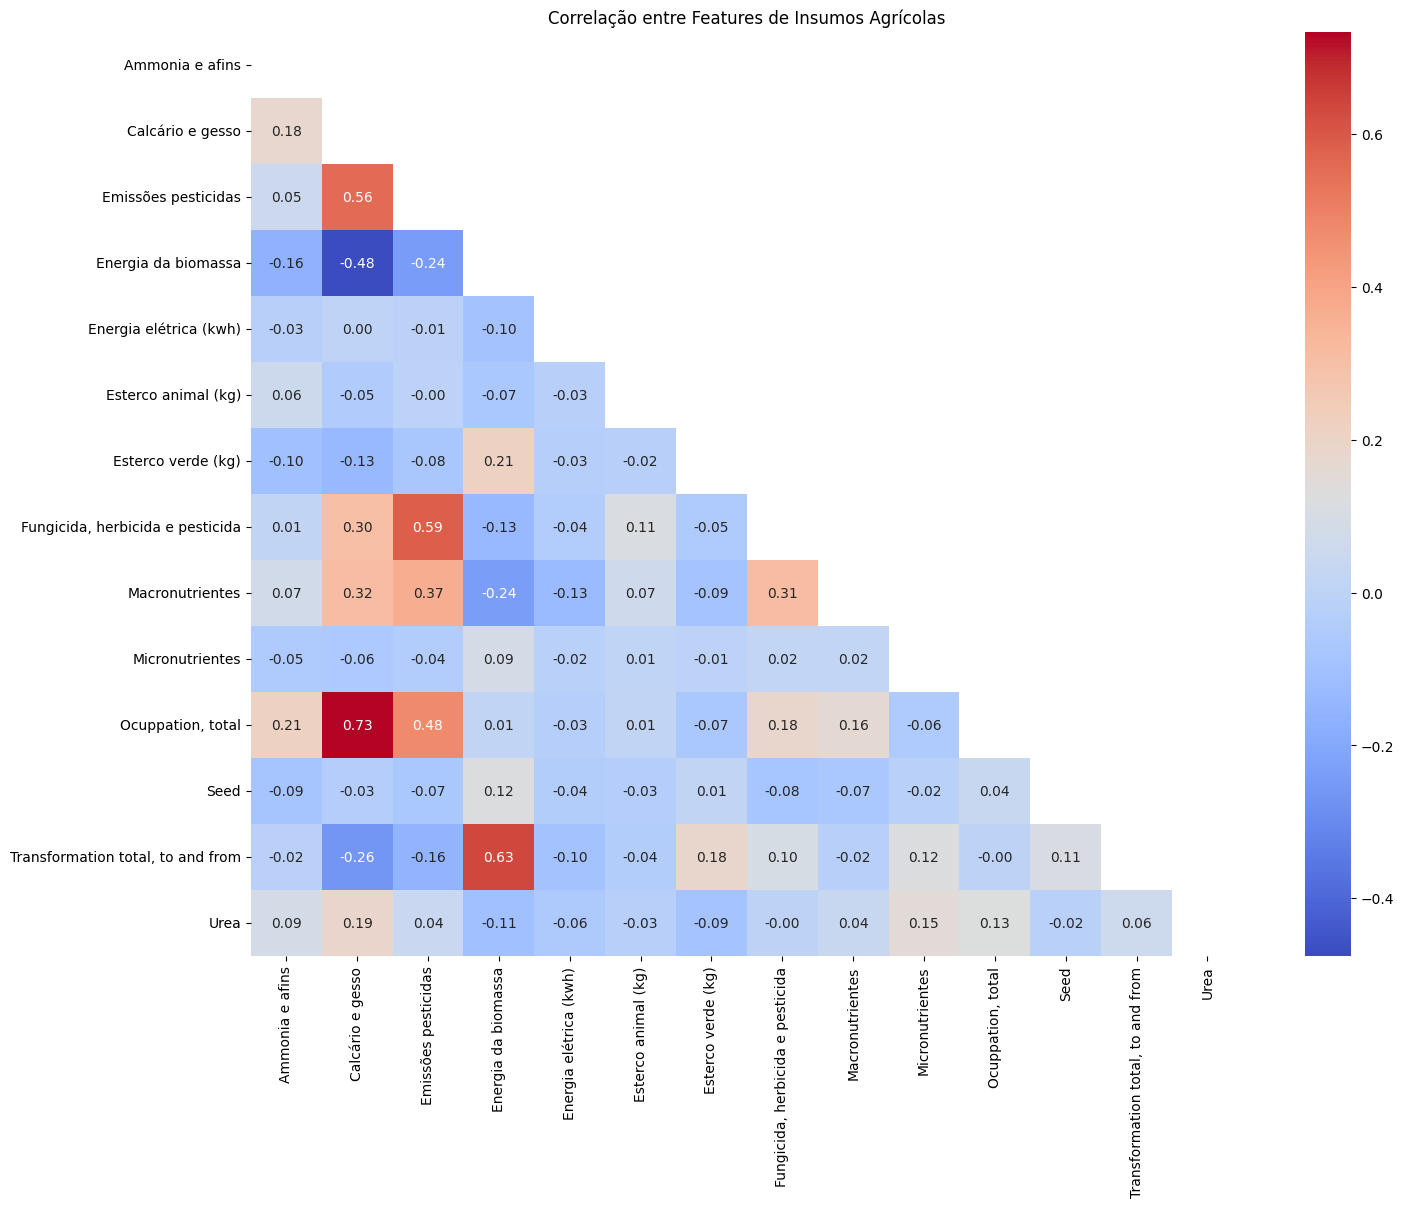

In [14]:
plt.figure(figsize=(16, 12))
corr_matrix = train[num_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlação entre Features de Insumos Agrícolas')